## Ejercicio Time Series Forecast
Para este ejercicio vamos a predecir cuál será la demanda de pasajeros de una aerolinea, para poder anticiparse a las contrataciones de personal, mantenimiento de las aeronaves y gestión de inventario y comidas.

Para ello, se pide:
1. Carga datos (AirPassengers.csv) y representa la serie. ¿Hay seasonality? ¿Cada cuanto?
2. Crea en una gráfica la variable original + su media obtenida mediante una rolling window con el valor de seasonality obtenido en el apartado anterior. Tienes que usar la función rolling() del DataFrame.
3. Comprueba de manera estadística si la serie es o no stationary.
4. Aplica una transformación logarítmica sobre los datos para mejorar el proceso de transformación de tu time series a stationary. Acuérdate después del forecast de invertir la transformación.
5. Divide en train y test. Guarda 20 muestras para test.
6. Crea tu primer modelo ARIMA. Habrá varias combinaciones en función de sus hiperparámetros... Mide el MAE y RMSE del modelo en predicción. Ten en cuenta el parámetro "m" de la función ARIMA, mediante el cual se establece el seasonality.
7. Representa en una gráfica los datos de test y tus predicciones.
8. Prueba un decission tree y un random forest, a ver qué performance presentan.

In [228]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from dateutil import parser
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

## 1. Carga datos y representa la serie

In [197]:
df = pd.read_csv(r'C:\Users\mareg\OneDrive\Documentos\TheBridge_Enero\Machine_Learning\3-Time_Series\ejercicios\data\AirPassengers.csv', parse_dates=['date'])

In [198]:
df.head()

,date,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [199]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    144 non-null    datetime64[ns]
 1   value   144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


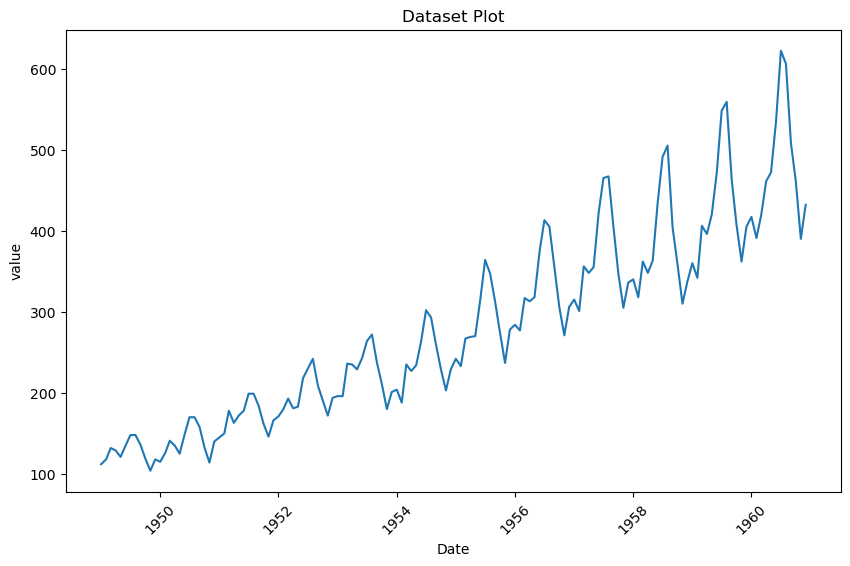

In [200]:

plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['value'])
plt.xlabel('Date')
plt.ylabel('value')
plt.title('Dataset Plot')
plt.xticks(rotation=45)
plt.show()

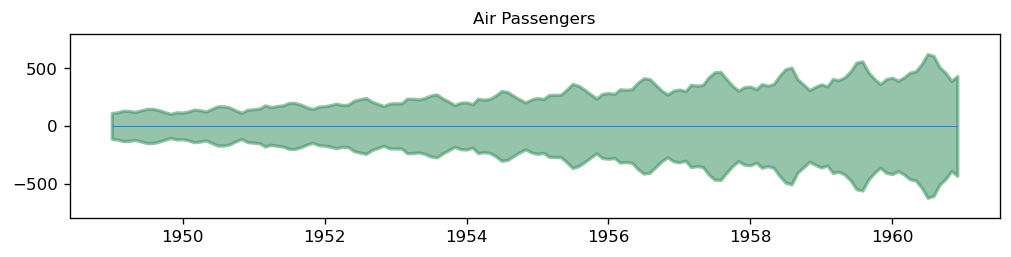

In [201]:
x = df['date'].values
y1 = df['value'].values

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10,2), dpi= 120)
plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
plt.ylim(-800, 800)
plt.title('Air Passengers', fontsize=10)
plt.hlines(y=0, xmin=np.min(df.date), xmax=np.max(df.date), linewidth=.5)
plt.show()

Cada 12 meses (he contado de pico a pico )

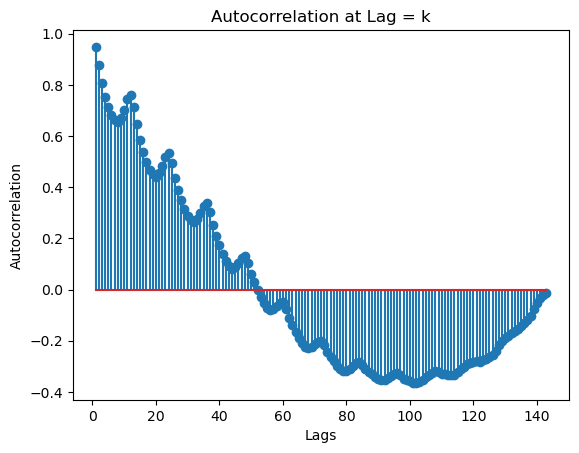

In [202]:
from statsmodels.graphics.tsaplots import acf
import matplotlib.pyplot as plt

# Calcular la autocorrelación en lags estacionales
lag_acf = acf(df['value'], nlags=143)

# Graficar la autocorrelación
plt.stem(range(1, 144), lag_acf[1:])
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation at Lag = k')
plt.show()

## 2. Crea en una gráfica la variable original + su media obtenida mediante una rolling window comparando el valor de seasonality obtenido en el apartado anterior

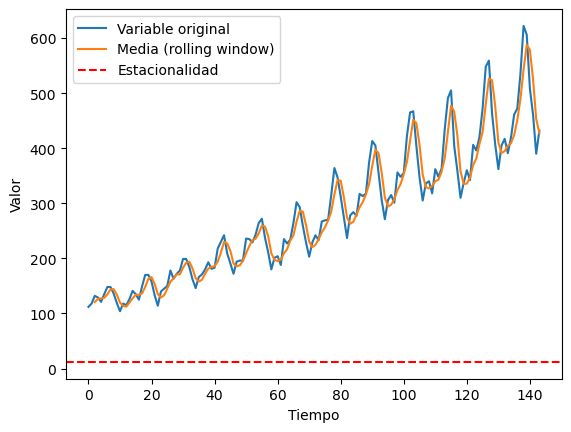

In [203]:
# Media obtenida mediante rolling window
ventana = 3  # Tamaño de la ventana deslizante
media_rolling = df['value'].rolling(window=ventana).mean()

# Valor de la estacionalidad
estacionalidad = 12

fig, ax = plt.subplots()
ax.plot(df['value'], label='Variable original')

#  rolling window
ax.plot(media_rolling, label='Media (rolling window)')

# estacionalidad
ax.axhline(estacionalidad, color='red', linestyle='--', label='Estacionalidad')

ax.legend()
ax.set_xlabel('Tiempo')
ax.set_ylabel('Valor')
plt.show()

## 3. Comprueba de manera estadística si la serie es o no stationary.

In [204]:
from statsmodels.tsa.stattools import adfuller

# Prueba de Dickey-Fuller Aumentada
result = adfuller(df['value'])

# Extraer el valor p y compararlo con un umbral para determinar la estacionaridad
p_value = result[1]
alpha = 0.05  

if p_value <= alpha:
    print("La serie es estacionaria.")
else:
    print("La serie no es estacionaria.")

La serie no es estacionaria.


## 4. Aplica una transformación logarítmica

In [205]:
# Desplazar la serie sumando 1
df_shifted = df['value'] + 1

df_log = np.log(df_shifted)
df_log.head()


0    4.727388
1    4.779123
2    4.890349
3    4.867534
4    4.804021
Name: value, dtype: float64

In [206]:
df_log.shape

(144,)

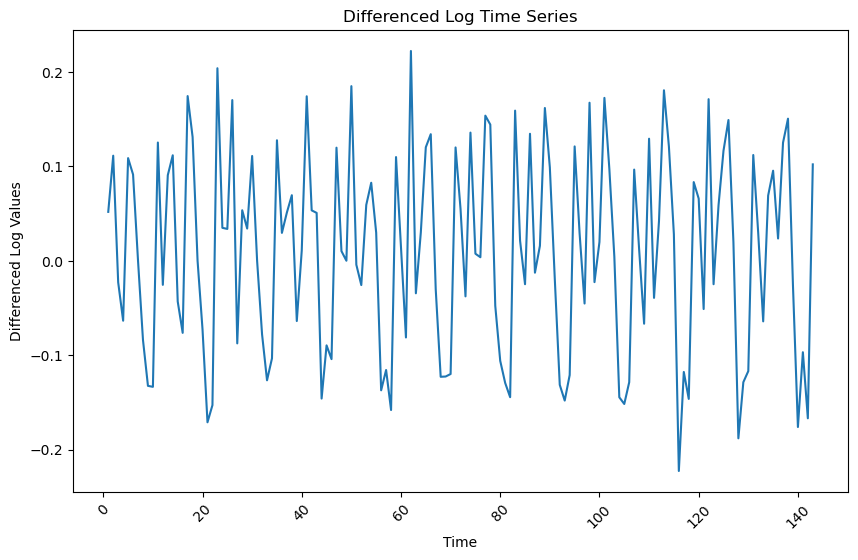

In [207]:
# Diferenciación de la serie de tiempo logarítmica para hacerla estacionaria (Elimino el primero que es Nan)
df_log_diff = df_log.diff().dropna()
plt.figure(figsize=(10, 6))
plt.plot(df_log_diff)
plt.xlabel('Time')
plt.ylabel('Differenced Log Values')
plt.title('Differenced Log Time Series')
plt.xticks(rotation=45)
plt.show()

In [208]:
df_log_diff.shape

(143,)

La transformación logarítmica se utiliza para estabilizar la varianza y reducir la tendencia, mientras que la diferenciación se aplica para eliminar la tendencia y la estacionalidad

## 5. Divide en train y test. Guarda 20 muestras para test.

In [209]:
from sklearn.model_selection import train_test_split

In [210]:
train, test = train_test_split(df_log_diff, test_size=20, shuffle=False)

print("Tamaño del conjunto de entrenamiento:", len(train))
print("Tamaño del conjunto de prueba:", len(test))

Tamaño del conjunto de entrenamiento: 123
Tamaño del conjunto de prueba: 20


## 6. Crea tu primer modelo ARIMA

In [211]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [212]:
m=12

In [213]:
# Crear el modelo ARIMA
model = ARIMA(train, order=(1, 0, 0), seasonal_order=(0, 0, 0, m))

# Ajustar el modelo ARIMA
model_fit = model.fit()

# Realizar predicciones en el conjunto de prueba
predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1)

# Calcular el MAE y RMSE
mae = mean_absolute_error(test, predictions)
rmse = np.sqrt(mean_squared_error(test, predictions))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 0.0990071671080236
RMSE: 0.1130976270962682


## 7. Representa en una gráfica los datos de test y tus predicciones.

Sin revertir las transformaciones

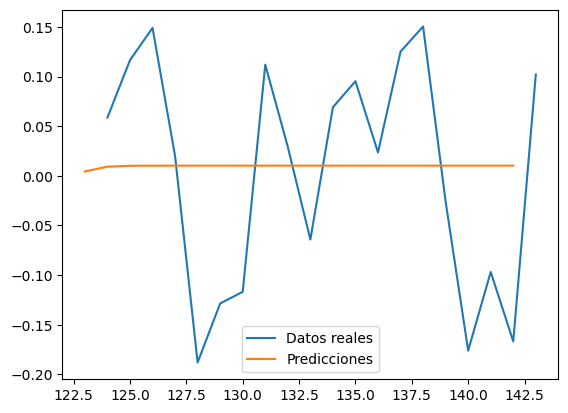

In [214]:
plt.plot(test, label='Datos reales')
plt.plot(predictions, label='Predicciones')
plt.legend()
plt.show()

Reinvierto la transformacion 

In [215]:
predictions_diff = predictions.cumsum()

In [216]:
predictions_inverse = np.exp(predictions_diff)

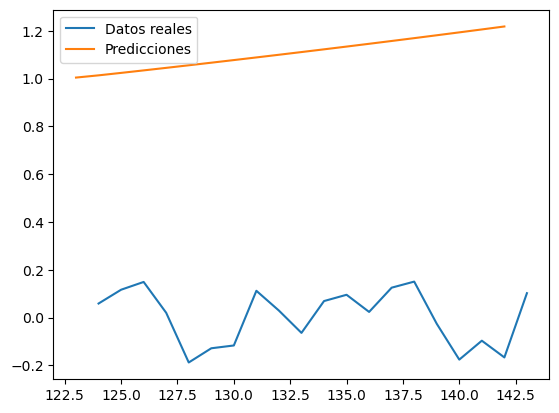

In [217]:
# Gráfico de las predicciones y los datos reales
plt.plot(test, label='Datos reales')
plt.plot(predictions_inverse, label='Predicciones')
plt.legend()
plt.show()

## 8. Prueba otros modelos, a ver qué performance presentan.

In [218]:
from statsmodels.tsa.api import SimpleExpSmoothing

# Crear el modelo de suavizado exponencial simple
model = SimpleExpSmoothing(train)

# Ajustar el modelo
model_fit = model.fit()

# Realizar predicciones en el conjunto de prueba
predictions = model_fit.forecast(len(test))

# Revertir las transformaciones y calcular las métricas
predictions_inverse = np.exp(predictions)
mae = mean_absolute_error(test, predictions_inverse)
rmse = np.sqrt(mean_squared_error(test, predictions_inverse))

print("MAE:", mae)
print("RMSE:", rmse)



MAE: 1.0059281210656972
RMSE: 1.012227731636743


In [219]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [220]:
p = 1  # Orden AR
d = 1  # Orden de diferenciación no estacional
q = 1  # Orden MA
P = 1  # Orden AR estacional
D = 1  # Orden de diferenciación estacional
Q = 1  # Orden MA estacional
s = 12  # Periodicidad estacionalidad 

In [221]:
model_sarima = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))

In [222]:
model_fit_sarima = model_sarima.fit()

In [223]:
predictions_sarima = model_fit_sarima.forecast(len(test))

In [224]:
predictions_inverse = np.exp(predictions_sarima) 

In [188]:
mae = mean_absolute_error(test, predictions_inverse)
rmse = np.sqrt(mean_squared_error(test, predictions_inverse))

print("MAE:", mae)
print("RMSE:", rmse)


MAE: 1.0046950981863614
RMSE: 1.0056972887645506


Decision Tree y Random forest 

In [229]:
#  modelo de árbol de decisión
tree_model = DecisionTreeRegressor(random_state=42)

tree_model.fit(X_train, y_train)

# Realizar predicciones con el modelo de árbol de decisión
tree_predictions = tree_model.predict(X_test)
#  métricas 
tree_mae = mean_absolute_error(y_test, tree_predictions)
tree_rmse = mean_squared_error(y_test, tree_predictions, squared=False)
print("Árbol de decisión:")
print("MAE:", tree_mae)
print("RMSE:", tree_rmse)



# modelo de bosque aleatorio
forest_model = RandomForestRegressor(random_state=42)
forest_model.fit(X_train, y_train)

forest_predictions = forest_model.predict(X_test)
#  métricas
forest_mae = mean_absolute_error(y_test, forest_predictions)
forest_rmse = mean_squared_error(y_test, forest_predictions, squared=False)

print("Bosque aleatorio:")
print("MAE:", forest_mae)
print("RMSE:", forest_rmse)

Árbol de decisión:
MAE: 3.4427420689655172e+16
RMSE: 4.312801127396089e+16
Bosque aleatorio:
MAE: 2.8481187475862068e+16
RMSE: 3.87397181641315e+16
